In [6]:
import os
import sys
import random
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import sumolib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import sys
import io
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
import pandas as pd


if 'SUMO_HOME' in os.environ:
    print('SUMO_HOME found')
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
import traci
from sumolib import checkBinary
sumoBinary = checkBinary('sumo-gui')
# sumoBinary = checkBinary('sumo')
roadNetwork = "./config/osm.sumocfg"
sumoCmd = [sumoBinary, "-c", roadNetwork, "--start", "--quit-on-end"]
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

SUMO_HOME found
Using device: cuda


## Check if there are parallel edges (multigrpah)

In [7]:
net = sumolib.net.readNet('./config/osm.net.xml.gz')

# Extract nodes and edges
nodes = net.getNodes()
edges = net.getEdges()

edges_from_to = {}
for edge in edges:
    from_node = edge.getFromNode().getID()
    to_node = edge.getToNode().getID()
    if (from_node, to_node) not in edges_from_to:
        edges_from_to[(from_node, to_node)] = [edge]
    else:
        edges_from_to[(from_node, to_node)].append(edge)

for from_node, to_node in edges_from_to.keys():
    if len(edges_from_to[(from_node, to_node)]) > 1:
        print(from_node, to_node)
        for edge in edges_from_to[(from_node, to_node)]:
            print(edge.getID())
            num_lanes = edge.getLaneNumber()
            speed_limit = edge.getSpeed()
            length = edge.getLength()

In [8]:
def randomTrips(dur=10000, density=12):
    os.system("python $SUMO_HOME/tools/randomTrips.py -n config/osm.net.xml.gz -r config/osm.passenger.trips.xml -e " + str(dur) + " -l --insertion-density=" + str(density))

def shouldContinueSim():
    numVehicles = traci.simulation.getMinExpectedNumber()
    return True if numVehicles > 0 else False

def restart(dur, density):
    with io.StringIO() as buf, redirect_stdout(buf):
        try:
            traci.close()
        except:
            pass
        randomTrips(dur, density)
        traci.start(sumoCmd)
        step = 0
        for i in range(100):
            traci.simulationStep()
            step += 1

In [9]:
def get_trajectories(dur=10000, density=12):
    randomTrips(dur, density)
    trajectories = {}
    traci.start(sumoCmd)
    while shouldContinueSim():
        traci.simulationStep()
        for vehicle in traci.vehicle.getIDList():
            if vehicle not in trajectories:
                trajectories[vehicle] = []
            x, y = traci.vehicle.getPosition(vehicle)
            speed = traci.vehicle.getSpeed(vehicle)
            direction = np.deg2rad(traci.vehicle.getAngle(vehicle))
            velocity_x = speed * np.sin(direction)
            velocity_y = speed * np.cos(direction)
            trajectories[vehicle] += [x, y, velocity_x, velocity_y]
    traci.close()
    return trajectories
trajectories = get_trajectories()

Success.
 Retrying in 1 seconds


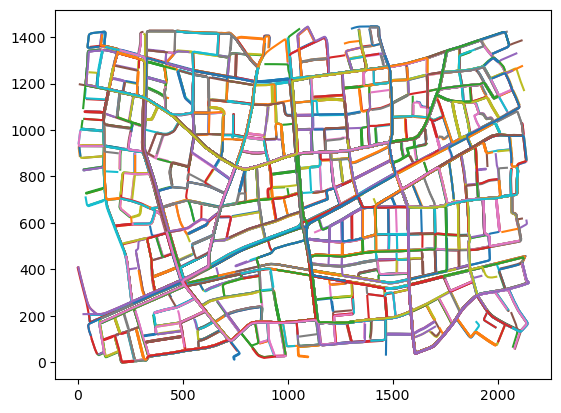

In [10]:
# plot the first 10 trajectories
def plot_trajectories(trajectories, n=10):
    for i, vehicle in enumerate(trajectories.keys()):
        if i > n:
            break
        trajectory = trajectories[vehicle]
        x = trajectory[::4]
        y = trajectory[1::4]
        plt.plot(x, y)
    plt.show()
plot_trajectories(trajectories, 1000)

In [12]:
# pad trajectories to have the same length
def pad_trajectories(trajectories):
    max_len = 0
    for vehicle in trajectories.keys():
        max_len = max(max_len, len(trajectories[vehicle]))
    for vehicle in trajectories.keys():
        trajectories[vehicle] += [0] * (max_len - len(trajectories[vehicle]))
    return trajectories

trajectories = pad_trajectories(trajectories)
df = pd.DataFrame(list(trajectories.values()), index=trajectories.keys())
print(df.head())
df.to_csv('fethiye_trajectories.csv')

          0            1     2     3            4            5         6     \
0   433.193805  1284.399904   0.0  -0.0   435.165249  1283.918327  1.971652   
1  1120.539062  1076.816745  -0.0   0.0  1120.460533  1078.912936 -0.078524   
2  1595.981725   133.813744  -0.0   0.0  1595.781039   136.312639 -0.200682   
3   522.004550   352.116405   0.0   0.0   523.577881   352.892454  1.573094   
4  1770.407289   853.071089   0.0  -0.0  1770.683511   851.303170  0.276220   

       7            8            9     ...  1978  1979  1980  1981  1982  \
0 -0.481627   439.035094  1282.973016  ...   0.0   0.0   0.0   0.0   0.0   
1  2.096059  1120.321572  1082.622245  ...   0.0   0.0   0.0   0.0   0.0   
2  2.498840  1595.410825   140.922459  ...   0.0   0.0   0.0   0.0   0.0   
3  0.775931   527.138734   354.648851  ...   0.0   0.0   0.0   0.0   0.0   
4 -1.767903  1771.264134   847.586987  ...   0.0   0.0   0.0   0.0   0.0   

   1983  1984  1985  1986  1987  
0   0.0   0.0   0.0   0.0   0.0  
